# Lab4

### import all libraries

In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

### load images

In [2]:
cereal_original = cv.cvtColor(cv.imread('cereal.jpg'),cv.COLOR_RGB2BGR)

cereal_left = cv.imread('cereal_l.jpg')
cereal_right = cv.imread('cereal_r.jpg')
cereal_target_left = cv.imread('cereal_tl.jpg')
cereal_target_right = cv.imread('cereal_tr.jpg')

cereal_original_gray = cv.cvtColor(cereal_original,cv.COLOR_BGR2GRAY)
cereal_left_gray = cv.cvtColor(cereal_left,cv.COLOR_BGR2GRAY)
cereal_right_gray = cv.cvtColor(cereal_right,cv.COLOR_BGR2GRAY)
cereal_target_left_gray = cv.cvtColor(cereal_target_left,cv.COLOR_BGR2GRAY)
cereal_target_right_gray = cv.cvtColor(cereal_target_right,cv.COLOR_BGR2GRAY)

### 1.1 Matching

In [3]:
# SIFT
my_SIFT_instance = cv.SIFT_create()
mask = None
[keypoints_original,descriptors_original] = my_SIFT_instance.detectAndCompute(cereal_original_gray,mask)
[keypoints_left,descriptors_left] = my_SIFT_instance.detectAndCompute(cereal_left_gray,mask)
[keypoints_right,descriptors_right] = my_SIFT_instance.detectAndCompute(cereal_right_gray,mask)
[keypoints_target_left,descriptors_target_left] = my_SIFT_instance.detectAndCompute(cereal_target_left_gray,mask)
[keypoints_target_right,descriptors_target_right] = my_SIFT_instance.detectAndCompute(cereal_target_right_gray,mask)

# Matcher
bf = cv.FlannBasedMatcher()
cereal_matches = bf.knnMatch(descriptors_original,descriptors_original, k=2)
match = cv.drawMatchesKnn(cereal_original_gray, keypoints_original, cereal_original_gray, keypoints_original, cereal_matches, None, flags=0)

# Lowe's Ratio's matches
def LoweRatioTest(match):  
    good_distance = []
    distance = []
    ratio_match = []
    query = []
    train = []
    for m,n in match:
        distance.append(m.distance)
        ratio = (m.distance)/(n.distance)
        if ratio < 0.8:
            ratio_match.append([m])
            m.queryIdx
            m.trainIdx
            query.append(m.queryIdx)
            good_distance.append(m.distance)
            train.append(m.trainIdx)
    return ratio_match,good_distance,distance,query,train

cereal_match,cereal_good_distance,cereal_distance,query,train = LoweRatioTest(cereal_matches)

### 1.2 Affine Transform

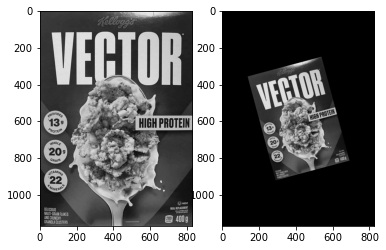

In [4]:
# Rotate
outpurt_image = []
angle = 15
scale = 0.5
size = (cereal_original.shape[1],cereal_original.shape[0])  
reference = cv.cvtColor(cereal_original,cv.COLOR_BGR2GRAY)
center = [int(size[0] / 2), int(size[1] / 2)]
rotation_matrix = cv.getRotationMatrix2D(center, angle, scale)
target = cv.warpAffine(reference, rotation_matrix, size, borderValue = (0,0,0))

plt.subplot(1,2,1)
plt.imshow(cereal_original_gray,cmap="gray")
plt.subplot(1,2,2)
plt.imshow(target,cmap="gray")

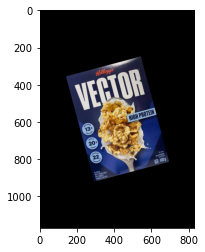

In [5]:
# Match 
[keypoints_target,descriptors_target] = my_SIFT_instance.detectAndCompute(target,mask) 

bf = cv.FlannBasedMatcher()
cereal_matches = bf.knnMatch(descriptors_original,descriptors_target, k=2)

cereal_match,_,_,query,train = LoweRatioTest(cereal_matches)

reference_points = np.float32([keypoints_original[m].pt for m in query]).reshape(-1,1,2)
image_points = np.float32([keypoints_target[m].pt for m in train]).reshape(-1,1,2)

affine_matrix, _ = cv.estimateAffinePartial2D(reference_points, image_points)
final = cv.warpAffine(cereal_original, affine_matrix, size, borderValue = (0,0,0))

outpurt_image.append(reference)

outpurt_image.append(final)
plt.imshow(final)

#### Since Affine transform doesn't work on perspective transfomed image, below will only show the perspective transform

### 1.3 Perspective Transform

In [6]:
def PerspectiveTransform(target,color_reference):
    [kpt,dst] = my_SIFT_instance.detectAndCompute(target,mask)

    bf = cv.FlannBasedMatcher()
    cereal_matches = bf.knnMatch(descriptors_original,dst, k=2)

    cereal_match,_,_,query,train = LoweRatioTest(cereal_matches)

    reference_points = np.float32([keypoints_original[m].pt for m in query]).reshape(-1,1,2)
    image_points = np.float32([kpt[m].pt for m in train]).reshape(-1,1,2)
    
    homography,_ = cv.findHomography(reference_points,image_points,cv.RANSAC) 
    color = cv.warpPerspective(color_reference,homography,dsize=(target.shape[1],target.shape[0])) 
    
    target_BGR = cv.cvtColor(target,cv.COLOR_GRAY2BGR)
    for i in range(target.shape[0]):
        for j in range(target.shape[1]):
            if color[i,j].all() != 0:
                target_BGR[i][j] = color[i][j]
    return target_BGR

<Figure size 1800x1200 with 0 Axes>

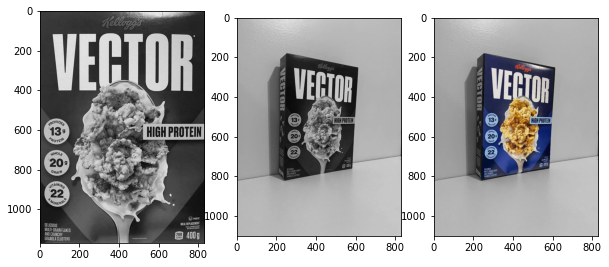

In [7]:
plt.figure(dpi=300)
plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(cereal_original_gray,cmap="gray")
plt.subplot(1,3,2)
plt.imshow(cereal_left_gray,cmap="gray")
plt.subplot(1,3,3)
plt.imshow(PerspectiveTransform(cereal_left_gray,cereal_original))

<Figure size 1800x1200 with 0 Axes>

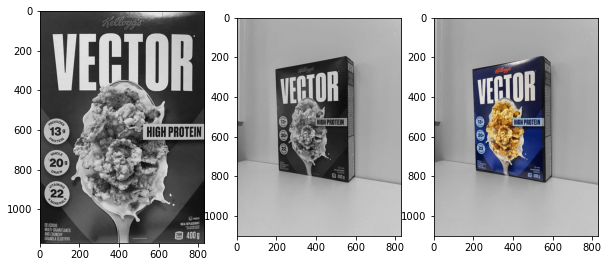

In [8]:
plt.figure(dpi=300)
plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(cereal_original_gray,cmap="gray")
plt.subplot(1,3,2)
plt.imshow(cereal_right_gray,cmap="gray")
plt.subplot(1,3,3)
plt.imshow(PerspectiveTransform(cereal_right_gray,cereal_original))

<Figure size 1800x1200 with 0 Axes>

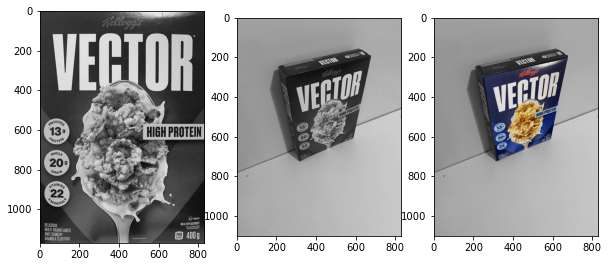

In [9]:
plt.figure(dpi=300)
plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(cereal_original_gray,cmap="gray")
plt.subplot(1,3,2)
plt.imshow(cereal_target_left_gray,cmap="gray")
plt.subplot(1,3,3)
plt.imshow(PerspectiveTransform(cereal_target_left_gray,cereal_original))

<Figure size 1800x1200 with 0 Axes>

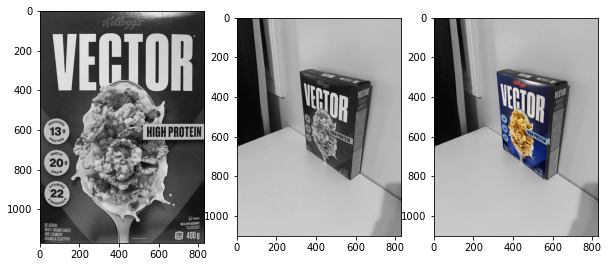

In [10]:
plt.figure(dpi=300)
plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(cereal_original_gray,cmap="gray")
plt.subplot(1,3,2)
plt.imshow(cereal_target_right_gray,cmap="gray")
plt.subplot(1,3,3)
plt.imshow(PerspectiveTransform(cereal_target_right_gray,cereal_original))